#### EDA
Student: Femke Bakker (13264443)
- Goal of the research: classify documents using LLMs
- The data consists of documents and their labels (classes). Besides the text from the pdfs there are no other features that will be used for the classification
- The EDA is performed on 20% of the dataset, because the dataset is very large (33000 docs).
- First de data is loaded in and some cleaning of the tokens is done. 
- Missing values, documents where no text was extracted from the PDFs, are already removed.


Link to github: https://github.com/Amsterdam-Internships/document-classification-using-large-language-models/tree/main 

In [1]:
!bash /home/azureuser/cloudfiles/code/blobfuse/blobfuse_raadsinformatie.sh

In [2]:
import sys
sys.path.append("..")

# Select where to run notebook: "azure" or "local"
my_run = "azure"

# import my_secrets as sc
# import settings as st

if my_run == "azure":
    import config_azure as cf
elif my_run == "local":
    import config as cf


import os
if my_run == "azure":
    if not os.path.exists(cf.HUGGING_CACHE):
        os.mkdir(cf.HUGGING_CACHE)
    os.environ["TRANSFORMERS_CACHE"] = cf.HUGGING_CACHE

import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# cleaned = pd.read_pickle(f"{cf.output_path}/txtfiles.pkl")
df = pd.read_pickle(f"{cf.output_path}/txtfiles_notcleaned.pkl")

In [111]:
# from nltk.corpus import stopwords
# import string
# import nltk
# nltk.download('stopwords')


# # remove stopwords
# top_df = df.copy()

# def remove_stopwords(tokens):
#     stop_words = set(stopwords.words('dutch'))
#     tokens_without_stopwords = [word for word in tokens if word.lower() not in stop_words]
#     tokens_without_punctuation = [word for word in tokens_without_stopwords if word not in string.punctuation and len(word)>1]
#     return tokens_without_punctuation


# df['cleaned_tokens'] = df['tokens'].apply(remove_stopwords)
# df['clean_text'] = df['cleaned_tokens'].apply(lambda x: ' '.join(x))



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Token & class distribution
Below are the tables shown for the complete dataset and the classes.

We can see that the token counts within the classes and between the classes are varying. This could create difficulties when converting the docs into suitable input for the LLMs. The LLMs have a max token limit, meaning that whole documents cannot be given as input and thus the docs need to be represented in another way. Furthermore, we can see the distribution of the amount of docs per class is some what even, with begroting being an outlier, with a lot of docs. Actualiteit and Factsheets are a little underrepresented compared to the other classes.
 
Note: the minimum values are very small. This is likely a result of mistakes made during converting PDF to OCR. Further expection is needed to remove bad files.

In [4]:
display(df)

,label,path,id,text,tokens,token_count,clean_tokens,clean_tokens_count,pdf_path,num_pages
0,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,0,Gemeente Amsterdam\n% Gemeenteraad R\n% Gemeen...,"[Gemeente, Amsterdam, %, Gemeenteraad, R, %, G...",395,"[Gemeente, Amsterdam, Gemeenteraad, Gemeentebl...",205,/home/azureuser/cloudfiles/code/blobfuse/raads...,2.0
1,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,1,Gemeente Amsterdam\n\n% Gemeenteraad R\n\n% Ge...,"[Gemeente, Amsterdam, %, Gemeenteraad, R, %, G...",390,"[Gemeente, Amsterdam, Gemeenteraad, Gemeentebl...",197,/home/azureuser/cloudfiles/code/blobfuse/raads...,2.0
2,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,2,Gemeente Amsterdam\n\n% Gemeenteraad R\n\n% Ge...,"[Gemeente, Amsterdam, %, Gemeenteraad, R, %, G...",389,"[Gemeente, Amsterdam, Gemeenteraad, Gemeentebl...",192,/home/azureuser/cloudfiles/code/blobfuse/raads...,2.0
3,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,3,Gemeente Amsterdam\n\n% Gemeenteraad R\n\n% Ge...,"[Gemeente, Amsterdam, %, Gemeenteraad, R, %, G...",464,"[Gemeente, Amsterdam, Gemeenteraad, Gemeentebl...",225,/home/azureuser/cloudfiles/code/blobfuse/raads...,2.0
4,Motie,/home/azureuser/cloudfiles/code/blobfuse/raads...,4,x Gemeente Amsterdam R\nGemeenteraad\n\n% Geme...,"[x, Gemeente, Amsterdam, R, Gemeenteraad, %, G...",261,"[Gemeente, Amsterdam, Gemeenteraad, Gemeentebl...",134,/home/azureuser/cloudfiles/code/blobfuse/raads...,1.0
...,...,...,...,...,...,...,...,...,...,...
33112,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33123,"In Amsterdam is, net als in andere delen van h...","[In, Amsterdam, is, ,, net, als, in, andere, d...",3816,"[Amsterdam, net, delen, land, sprake, tekort, ...",2001,/home/azureuser/cloudfiles/code/blobfuse/raads...,10.0
33113,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33124,| September 2021 C 1 / )\nr 1E | rs | a 4 in\n...,"[|, September, 2021, C, 1, /, ), r, 1E, |, rs,...",85228,"[September, 2021, 1E, rs, ke, We, ear, nrc, TW...",43467,/home/azureuser/cloudfiles/code/blobfuse/raads...,164.0
33114,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33125,WPI KWARTAAL FACTSHEET DECEMBER 2022\nKERNCIJF...,"[WPI, KWARTAAL, FACTSHEET, DECEMBER, 2022, KER...",1595,"[WPI, KWARTAAL, FACTSHEET, DECEMBER, 2022, KER...",970,/home/azureuser/cloudfiles/code/blobfuse/raads...,7.0
33115,Factsheets,/home/azureuser/cloudfiles/code/blobfuse/raads...,33126,"WPI VOORTGANGSRAPPORTAGE\nKERNCIJFERS WERK, PA...","[WPI, VOORTGANGSRAPPORTAGE, KERNCIJFERS, WERK,...",1821,"[WPI, VOORTGANGSRAPPORTAGE, KERNCIJFERS, WERK,...",1024,/home/azureuser/cloudfiles/code/blobfuse/raads...,6.0


count     33117.000000
mean       2691.847933
std       13409.818780
min           3.000000
25%         291.000000
50%         533.000000
75%        1225.000000
max      275597.000000
Name: token_count, dtype: float64

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Actualiteit,996.0,696.773092,3462.293848,72.0,236.00,344.5,592.0,103700.0
Adviesaanvraag,2442.0,1644.871417,2993.302964,57.0,557.00,955.0,1672.0,77769.0
Agenda,3537.0,1048.904156,4244.783305,20.0,325.00,616.0,939.0,139648.0
Amendement,1969.0,2658.493652,7044.470410,30.0,236.00,359.0,1184.0,62304.0
Begroting,1967.0,13160.190646,46780.793626,40.0,248.00,385.0,2324.0,247184.0
Besluit,775.0,986.649032,1749.006500,70.0,168.50,439.0,1216.0,26523.0
Brief,1995.0,1764.259649,1728.612069,3.0,734.00,1269.0,2291.5,32957.0
Factsheets,234.0,6008.987179,14742.837685,112.0,1154.00,2753.5,5462.0,171297.0
Motie,8336.0,521.707893,1129.571368,105.0,234.00,292.5,402.0,36091.0


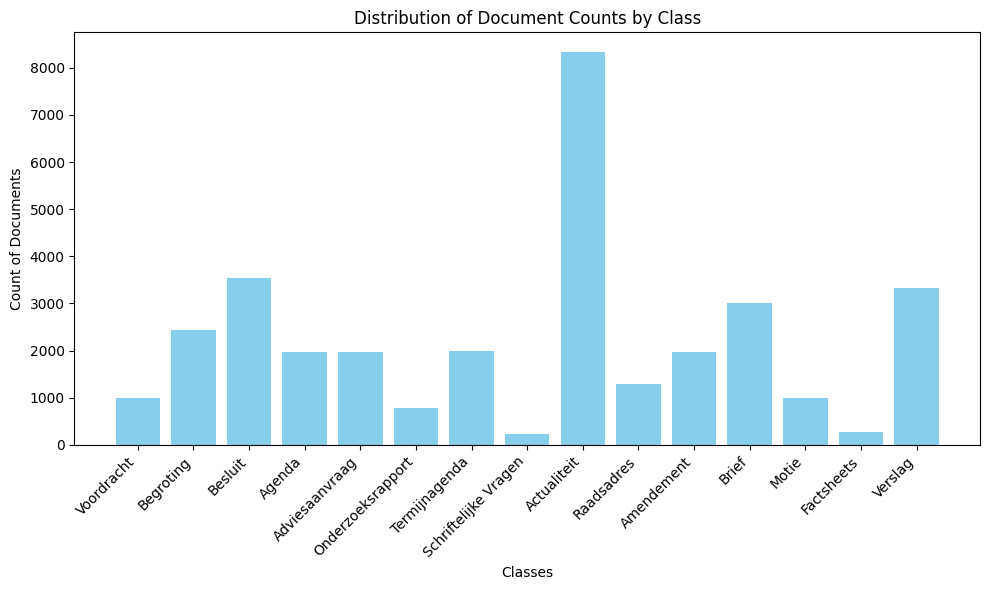

In [5]:
display(df['token_count'].describe())
class_describe = df.groupby('label')['token_count'].describe()
display(class_describe)

classes = list(set(df['label']))
counts = list(class_describe['count'])

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Count of Documents')
plt.title('Distribution of Document Counts by Class')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

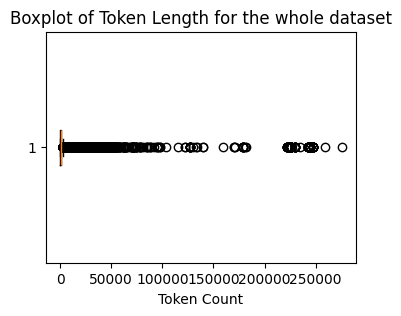

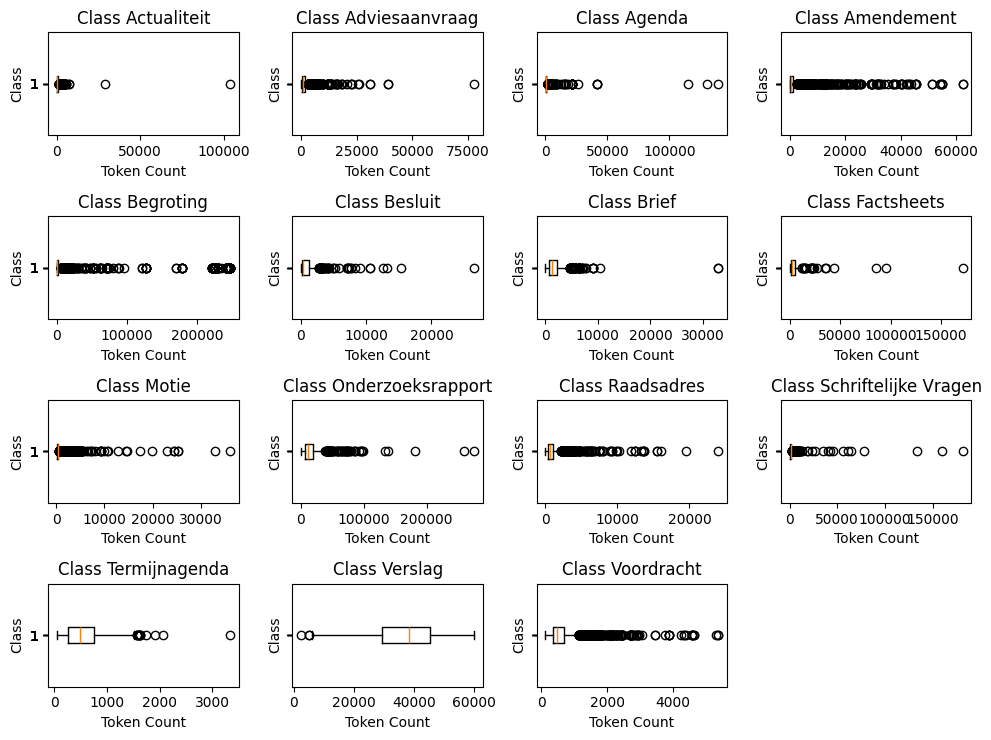

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.boxplot(df['token_count'], vert=False)
plt.title('Boxplot of Token Length for the whole dataset')
plt.xlabel('Token Count')
plt.show()

grouped = df.groupby('label')

# Create subplots
fig, axs = plt.subplots(4, 4, figsize=(10, 7.5), sharey=True)

# Iterate over groups and plot boxplots
for i, (label, group) in enumerate(grouped):
    row = i // 4
    col = i % 4
    axs[row, col].boxplot(group['token_count'], vert=False)
    axs[row, col].set_title(f'Class {label}')
    axs[row, col].set_xlabel('Token Count')
    axs[row, col].set_ylabel('Class')

# Hide empty subplots if any
for i in range(len(grouped), 4*4):
    row = i // 4
    col = i % 4
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

Based on the plots above we can see that there a classes that dont have (many) outliers in token counts, such as termijnagenda, verslag and brief. On the other hand there are also classes that have many outliers in token count, such as voordracht, begroting and moties. It's noticeable that the outliers are on the right side, meaning that the outliers have a high token count. 

#### Top words for each class

The goal is to find words that are identifiers for the classes. We suspect that the name of the class, for example 'agenda', 'motie', 'begroting', will be strong identicators for a class. However, we also know that these words are used in documents that don't belong to that class. The goal of this part of the analysis is to find how severe this is. 

1. select top 50 words with highest TF-IDF mean for each class. 

2. Then select the unique words for each class. Words that do not occur in the top-50 of other classes.

3. Check if other class names are named in docs of a class.

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

df['clean_text'] = df['clean_tokens'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['label'] = df['label']

# Calculate mean TF-IDF score for each word across all documents in each class
mean_tfidf_by_class = tfidf_df.groupby('label').mean()

# Get top 50 words with highest mean TF-IDF score for each class
top_50_words = {}
for class_name, class_tfidf in mean_tfidf_by_class.iterrows():
    top_50_words[class_name] = class_tfidf.nlargest(50).index.tolist()

In [8]:
unique_words_dict = {}
for class_name in top_50_words.keys():
    top_words = top_50_words[class_name]

    all_other_words = []
    for other_name in top_50_words.keys():
        if class_name != other_name:
            all_other_words.extend(top_50_words[other_name])
    all_other_words = set(all_other_words)

    unique_words = [word for word in top_words if word not in all_other_words]
    print(f'{class_name}: ---- {unique_words}')




Actualiteit: ---- ['actualiteit', 'spoedeisendheid', 'reden', 'raadsactualiteit', 'behandeling', 'maart', 'poot', 'supplement', 'wassink', 'februari', 'indieners']
Adviesaanvraag: ---- ['stadsdeelcommissie', 'adviesaanvraag', 'art', 'concept', 'stadsdelen', 'staf', 'invullen', '2605', '81484', 'adviezen', 'z17', 'sdc', 'verordening', 'directie', 'kaders', 'kader', 'meegestuurde', 'weekstart', 'conceptadvies', 'procesbegeleider', 'formuleer', 'vraagt', 'optioneel']
Agenda: ---- ['agendapunten', 'aanvang', 'dient']
Amendement: ---- ['pvda', 'stadsdeelraad', 'sp', 'dhr', 'groenlinks', 'deelraad', 'bijeen', 'bnw81', 'cda', 'dag']
Begroting: ---- ['2010', '2009', '2008', 'miljoen', '2007', 'december', 'lasten', 'baten', 'reserve', 'euro', 'reserves', 'kosten', 'middelen', 'saldo', 'behandelen', 'bedrag']
Besluit: ---- ['algemeen', 'ab', 'int', 'bestemmingsplan', 'decos', 'nieuwwest', 'ivar', 'baâdoud', '1064', '14020', 'wink', 'sw', '2003', 'plein', 'stadsdeelsecretaris', 'bestuurscommissie

In [10]:

# get dict with all tokens (including duplicates) for each class
tokens_class = dict()
for class_name in set(df['label']):
    all_tokens = list(df.loc[df['label']==class_name]['clean_tokens'].values)
    all_tokens = [token for sublist in all_tokens for token in sublist]
    tokens_class[class_name] = all_tokens

# For each class count how many times the class names are in the tokens
df_col = list(tokens_class.keys())
df_col.append("Total Doc in Class")
class_count_df = pd.DataFrame(columns=df_col)

for class_name in tokens_class.keys():
    tokens = tokens_class[class_name]
    counts = {label: tokens.count(label.lower()) for label in tokens_class.keys()}
    counts['Total Doc in Class'] = len(df.loc[df['label']==class_name])
    class_count_df.loc[len(class_count_df)] = counts

class_count_df.set_index(pd.Index(list(tokens_class.keys())), inplace=True)


# high the df to make result more interpretable
def highlight_max_and_second_highest_except_total(s):
    max_val = s[:-1].max()
    second_max_val = s[:-1].nlargest(2).iloc[-1]  # Get the second largest value
    is_max = s[:-1] == max_val
    is_max['Total Doc in Class'] = False
    is_second_max = s[:-1] == second_max_val
    is_second_max['Total Doc in Class'] = False

    styles = ['background-color: green' if v else '' for v in is_max]
    styles_second = ['background-color: orange' if v else '' for v in is_second_max]
    combined_styles = [f'{styles[i]}; {styles_second[i]}' for i in range(len(styles))]
    return combined_styles

styled_df = class_count_df.style.apply(highlight_max_and_second_highest_except_total, axis=1)

display(styled_df)




,Voordracht,Begroting,Besluit,Agenda,Adviesaanvraag,Onderzoeksrapport,Termijnagenda,Schriftelijke Vragen,Actualiteit,Raadsadres,Amendement,Brief,Motie,Factsheets,Verslag,Total Doc in Class
Voordracht,374,685,4743,261,33,81,19,0,37,562,96,1812,5619,7,108,3332
Begroting,467,41867,3362,1403,121,36,43,0,120,3,1346,863,4207,4,139,1967
Besluit,271,245,2383,46,46,40,0,0,5,4,32,380,102,0,29,775
Agenda,200,1212,701,10683,87,45,214,0,115,4724,87,3526,2877,1,333,3537
Adviesaanvraag,192,95,2112,341,4221,6,0,0,10,0,70,549,280,3,37,2442
Onderzoeksrapport,93,1684,1715,1083,29,137,7,0,79,10,48,775,713,75,369,1286
Termijnagenda,11,83,90,2414,47,3,313,0,6,139,15,93,270,0,125,996
Schriftelijke Vragen,56,333,1033,183,5,47,13,0,29,77,51,1677,529,5,115,3004
Actualiteit,71,75,408,351,10,6,3,0,743,808,19,1620,1296,0,32,996
Raadsadres,40,122,830,116,1,5,0,0,9,1606,41,2545,165,0,83,1975


The green marked values are the highest count in that row and the orange ones are the second highest. We want the class_name to be named a lot in the class and very few in the other classes, that means that the class name is an identifier for that class. 

Notes:
- schriftelijke vragen is never named in the docs. Which is understandable, since schriftelijke vragen are questions about very different subjects
- the distinction between agenda and termijnagenda might be hard, based on the count of agenda and termijnagenda in them. They both name agenda a lot.
- Verslag might be confused with Motie, since motie is named very often. 

Overall there is quite some overlap between the classes, in regards of naming the class names. 



### Similarity within class

If the docs within a class are similar, it will be easier to classify them, because then patterns are easier to identify by the model. The average cosine similarity between docs of a class is calculated. Since the texts need to be shortened to give as input, the similarity of the first 1000 tokens of each doc is also compared.

We can see in the tables below the similarity of the documents within the classes. It shows that the documents are not similar to each other, since the scores are low. 
Verslag is the class with the highest similarity between the documents. Additionally, the documents are more similar if the whole document is compared, than when the first 1000 tokens of the docs are compared. This could be a problem, or at least worse the performance if the docs are represented by the first N tokens. This could mean that other representation methods such as summarizing might be a better fit to represent the docs.


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import math
import numpy as np


def similarity_within_class(input_df, text_len):
    work_df = input_df.copy()
    within_sim = pd.DataFrame(columns=['label', 'average_sim', 'num_pairs_exceeding_threshold'])

    # if not complete
    if text_len == 'complete':
        text_column = 'text'

    else:
        work_df['short_text'] = work_df['tokens'].apply(lambda tokens: ' '.join(tokens[:text_len]))
        text_column = 'short_text'


    for category in set(work_df['label']):
        subdf = work_df.loc[work_df['label']==category]

        # get tf-idf score
        tfidf_vectorizer = TfidfVectorizer()
        tfidf_matrix = tfidf_vectorizer.fit_transform(subdf[text_column])

        # calculate cosine similarity
        cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

        # take average sim
        average_similarity = round(np.mean(cosine_similarities), 2)

        # calculate how many pairs succeed threshold
        total_possible_pairs = len(cosine_similarities) * (len(cosine_similarities))
        num_pairs_exceeding_threshold = round(np.sum(cosine_similarities > 0.5) / total_possible_pairs, 2)

        # add to df
        within_sim.loc[len(within_sim)] = {'label':category, 'average_sim': average_similarity, 'num_pairs_exceeding_threshold':num_pairs_exceeding_threshold}

        within_sim = within_sim.sort_values(by='average_sim', ascending=False)
    return within_sim

# sim_within_df_500tokens = similarity_within_class(df, 500)
# display(sim_within_df_500tokens)

sim_within_df_1000tokens = similarity_within_class(df, 1000)
display(sim_within_df_1000tokens)

sim_within_df_cleantext = similarity_within_class(df, 'complete')
display(sim_within_df_cleantext)


,label,average_sim,num_pairs_exceeding_threshold
14,Verslag,0.47,0.32
4,Adviesaanvraag,0.28,0.01
11,Brief,0.26,0.00
7,Schriftelijke Vragen,0.25,0.00
3,Agenda,0.24,0.04
2,Besluit,0.20,0.01
6,Termijnagenda,0.19,0.05
0,Voordracht,0.18,0.00
1,Begroting,0.18,0.00
5,Onderzoeksrapport,0.18,0.01


,label,average_sim,num_pairs_exceeding_threshold
14,Verslag,0.91,1.00
5,Onderzoeksrapport,0.48,0.47
4,Adviesaanvraag,0.34,0.05
11,Brief,0.33,0.05
1,Begroting,0.30,0.07
7,Schriftelijke Vragen,0.29,0.00
3,Agenda,0.26,0.05
13,Factsheets,0.25,0.05
2,Besluit,0.22,0.01
10,Amendement,0.22,0.03
